# 2. End-to-End Machine Learning Project

In this Chapter, we will go through a fictitious Machine Learning project on real estate.

We will go through the following steps:

1. Look at the big picture
2. Get the data
3. Discover and visualize the data to gain insights
4. Prepare the data for Machine Learning algorithms
5. Select a model and train it
6. Fine-tune our model
7. Present our solution
8. Launch, monitor, and maintain our system

### 1. Look at the big picture

Three main things to do:

1. **Frame the problem**：what is the final objective?
2. **Select a performance measure**: how do we know how well is our algorithm performing? 
3. **Check the assumptions**: what did we assume so far? 

### 2. Get the data

First thing to do is to create the **workspace**. 
Another important step is creating an isolated environment so we can work on different projects without having conflicting library versions. 

Now we can start working with our Housing dataset. Let's download it using a short script:

In [1]:
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [4]:
# download the data
fetch_housing_data()

In [5]:
# load data using pandas
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
# check the data structure
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
# examine attribute types and number of non-null values
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Note how `total_bedrooms` has only 20,433 non-null values, compared to 20,640 for the rest.

Let's inspect `ocean_proximity`, the only category which is not a numberical attribute (`float64` data type):

In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

For numberical attributes, we can use the `describe()` method:

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another quick way to get a feel of the type of data you are dealing with is to plot a **histogram** for each numerical attribute.

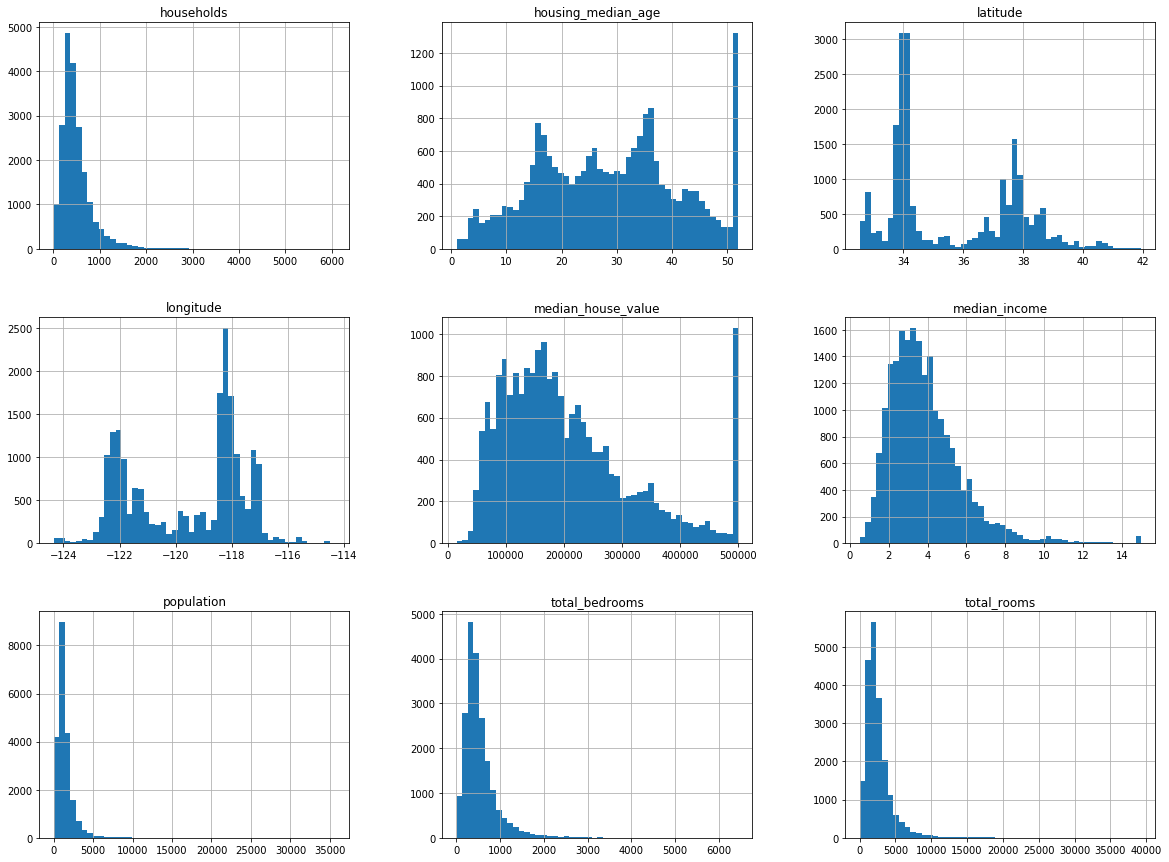

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

#### Creating a Test Set

It is good practice to set aside a portion of the dataset as test set as soon as possible (and not look at it ever again!).  
Typically we can do this by setting aside 20% of the original dataset: 

In [11]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

However, this has a problem: everytime we run the program again it will generate a different test set so over time, you will go through the whole dataset again. Not good. 

Possible solutions:
1. Save the test set on the first run and then load it in subsequent runs
2. Set the random number generator’s seed (e.g.,  `np.ran dom.seed(42)`) always to same value before calling `np.random.permutation()` 

**Note**: clearly, my seed was chosen very very randomly here. 

However, both these may break with updated datasets. A common solution is to use each instance’s identifier to decide whether or not it should go in the test set (_assuming instances have a unique and immutable identifier_).

In [12]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, our housing dataset does not have an identifier column. We could use the row index as id: 

In [13]:
import numpy as np

housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

However, this creates contraints: we can only append at the end of the dataset, and no row can be deleted.  
Aleternatively, we could use latitute and longitude:

In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

Next, to ensure **stratified sampling**, we may want to create an income category attribute with 5 categories:

In [15]:
housing["income_cat"] = pd.cut(housing["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])

We can now to stratified sampling using Scikit-learn's `StratifiedShuffleSplit` class:

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let's see the proportion that went in different bins:

In [17]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Let's remove the `income_cat` attribute so the data is back to its original state:

In [18]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### 3. Discover and visualize the data to gain insights

1. We are only exploring the **training set**
2. If dataset is to big, it's good to have an **exploration set** for ease of manipulation
3. Always make a copy so you can mess around without worries

In [19]:
housing = strat_train_set.copy()

### Visualizing geographical data

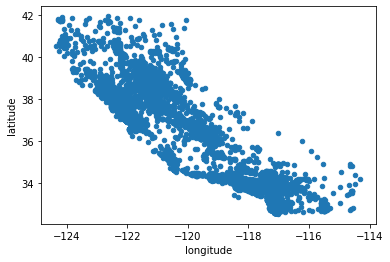

In [20]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude")

Let's diminuish alpha so we can see where there is a higher density of points:

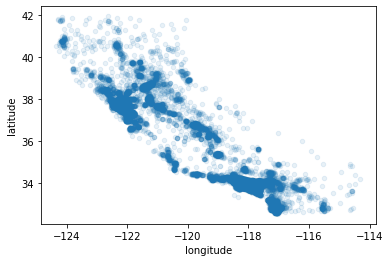

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Now let’s look at the housing prices, with circle radius representing population and color representing price:

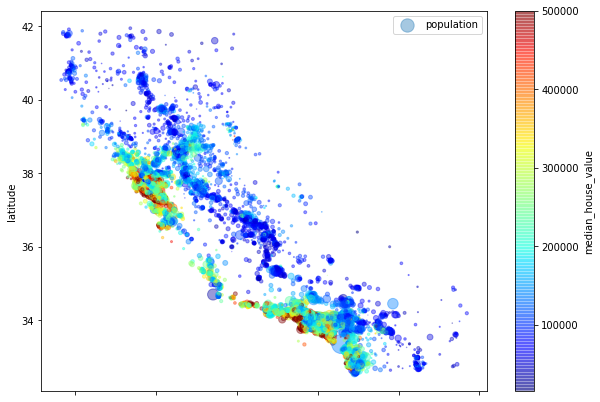

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

### Looking for correlations

Using the Pearson's coefficient to measure **linear correlation**:

In [23]:
corr_matrix = housing.corr()

In [24]:
# let's look at median_house_value as an example
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Another method involves Pandas' `scatter_matrix` function:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021FB67CE508>,
      dtype=object)

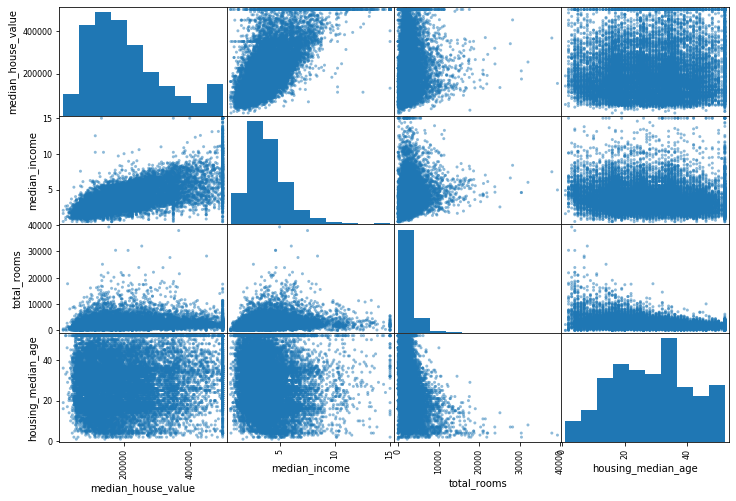

In [25]:
# only focusing on a 4 x 4 subset of all the possible 11 x 11 plots
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
            "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

Let's look in more detail into the variable with the highest predictive power `median_income` using a scatter plot:

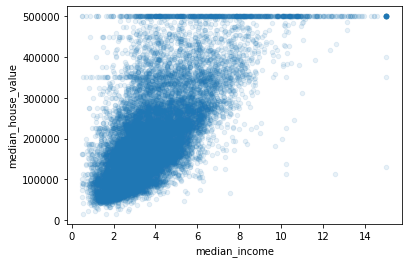

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1)

Our 500,000 dollars ceiling is clearly visible, and there are a few other horizontal lines (e.g. around 350,000) worth investigating further.

### Experimenting with attribute combinations

Sometimes default "pure" attributes are not the most relevant. For example, it may be useful to know the number of rooms per household rather than the two attributes independently. 
We can construct these new attributes by ourselves:

In [27]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [28]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

### Prepare the data

There are a few arguments for doing this programmatically rather than manually:
1. Reproduce these transformations on any dataset
2. Build a library of reusable transformation functions
3. Use these functions in your live system to transform data before feeding it to algorithms
4. Easily try various transformations and see which combination of transformations works best

In [29]:
# separating predictors and target values

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Data cleaning

Fist, let's take care of missing values for `total_bedrooms`. We have 3 options here:
1. Get rid of corresponding districts
2. Get rid of whole attribute
3. Fill in the missing values

In code, these options look like this:

In [30]:
housing.dropna(subset=["total_bedrooms"])   # option 1
housing.drop("total_bedrooms", axis=1)      # option 2
median = housing["total_bedrooms"].median() # option 3 with median
housing["total_bedrooms"].fillna(median, inplace=True)

In Scikit-Learn there is a handy class for missing values: `SimpleImputer`:

In [31]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Since this will only work on numerical values, we need to create a copy without the text attribute `ocean_proximity`:

In [32]:
housing_num = housing.drop("ocean_proximity", axis=1)

Now we can fit the imputer instance to the training data:

In [33]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [34]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [35]:
# checking that the median has been computed correctly
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now we can transform the training set by replacing missing values by the learned medians:

In [36]:
X = imputer.transform(housing_num)

**Note**: we could do these two steps (`fit` and `transform`) much faster using `fit_transform`. 

### Handling text and categorical attributes

In order to be able to work with text attributes, we could convert them from text to numbers using the `OrdinalEncoder` class:

In [37]:
from sklearn.preprocessing import OrdinalEncoder

housing_cat = housing[["ocean_proximity"]]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

# check
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be true sometimes but definitely not in this case.  
To fix this issue, a common solution is to create a binary attribute (*dummy variables*) in a process known as *one-hot encoding*. 

In [38]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

**Note** SciPy sparse matrix means that instead of storing all the 0s and 1s, we only store the location of 1s.  

We can get back to dense Numpy arrays like this:

In [39]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

#### Custom transformers

To be compatible with Scikit-learn, you need to create a class and implement three methods: `fit()`, `tranform()` and `fit_transform`.  

We can get the last one by simply adding `TransformerMixin` as a base class. Also, if we add `BaseEstimator` as a base class and avoid `*args` and `**kargs` we will get two extra methods (`get_params()` and `set_params()`). 

Example:

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room: # conditional to hyperparameter
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example we have one hyperparameter `add_bedrooms_per_room` set on `True` by default.  

Setting hyperparameter is a good way to simplify tuning in the future and automate data preparation steps.

#### Feature scaling

Machine Learning algorithms usually don't perform very well on attributes that have very different scales. We have to options to solve this:

1. **Min-max scaling / Normalization** (`MinMaxScaler`) returns number in range [0,1] = $\displaystyle \frac{value - min}{max - min}$  
2. **Standardization** (`StandardScaler`) does not return value in specific range = $\displaystyle \frac{value - \mu}{\sigma}$ 

**Note**: since it does not depend on single values (max and min), standardization is less affected by outliers. 

#### Transformation pipelines

To help with pipelines (sequences of transformations), Scikit-Learn provides the (.. drum roll ..) `Pipeline` class. Here is an example for numerical attributes:

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column.  

This is exactly what `ColumnTransformer` does, and it works very well with Pandas dataframes:

In [42]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

**Note 1**: In order to decide if returning a sparse or dense matrix, we can set a threshold value so that if density < threshold we will go for a sparse matrix. 
The default is set to **0.3**.  

**Note 2**: We can also `drop` the columns or `pass through` them, doing nothing. 

**Note 3**: By default, columns not explicitely mentioned will be dropped. You can set the `remainder` parameter to handle these cols differently. 

### 5. Select and train a model

#### Training and Evaluating on the Training Set

Let's first train a simple Linear Regression model:

In [43]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's try our model on a few instances:

In [44]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [45]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works, although it is clearly not very accurate. Let's check the root mean square error (RMSE) for the whole dataset:

In [46]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Quite high. This could be due to the quality of the data we have or to the level of sophistication in our model. 

Let's try a more complex model to see how things change:

In [47]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [48]:
# evaluation of training set

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Perfect model?! No. Probably a bad case of overfitting. 

#### Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the `train_test_split` function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set.

An alternative is using Scikit-Learn k-fold cross-validation feature:

In [49]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [50]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69962.98390482 67685.1347743  71352.09626963 70839.1370442
 70972.8183015  74916.80446225 70239.22401325 69630.28889325
 76033.63211288 70705.95123181]
Mean: 71233.80710079047
Standard deviation: 2342.8151122123295


Wow, it managed to do worse than the linear regression model. Just to be sure, let's compute the scores for the Linear Regression as well:

In [51]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                            scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798349


Yep, our Decision Trees model overfits the data so badly to underperform our linear regression model. 

Third model: Random Forests.

In [52]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

C:\Users\giuse\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22282.418169517194

In [53]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)

Scores: [51986.03404648 49082.85154098 52047.19166795 53711.50938014
 51916.72549228 55408.29812713 52151.76926796 49593.79952147
 54857.65854355 53659.46040827]
Mean: 52441.529799621865
Standard deviation: 1945.4624789709396


On the other hand, Random Forests looks quite promising, albeit probably still overfitting. Possible solutions are regularization and collecting more training data.

**Best practice**: save each model (with hyperparameters, trained parameters, cross-validation scores and actual predictions) to easily compare different models.

In [54]:
from sklearn.externals import joblib

joblib.dump(forest_reg, "forest_reg.pkl")

# and later...
my_model_loaded = joblib.load("forest_reg.pkl")

C:\Users\giuse\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### 6. Fine-tune our model

#### Grid search

`GridsearchCV` is great to automate hyperparameters tuning. Input hyperparameters and values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation. 

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}, 
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,  # five-fold cross validation
                            scoring='neg_mean_squared_error',
                            return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [56]:
# best combination of parameters
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [57]:
# best estimator
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

**Note**: If  GridSearchCV is initialized with `refit=True` (which is the default), then once it finds the best estimator using cross-validation, it retrains it on the whole training set. This is usually a good idea since feeding it more data will likely improve its performance.

In [58]:
# evaluation scores
cvres = grid_search.cv_results_

In [59]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64367.93554275344 {'max_features': 2, 'n_estimators': 3}
55303.71171078825 {'max_features': 2, 'n_estimators': 10}
52839.011670088345 {'max_features': 2, 'n_estimators': 30}
60089.954683855365 {'max_features': 4, 'n_estimators': 3}
52933.900202768375 {'max_features': 4, 'n_estimators': 10}
50462.61442108074 {'max_features': 4, 'n_estimators': 30}
58983.84176597527 {'max_features': 6, 'n_estimators': 3}
52092.600449961996 {'max_features': 6, 'n_estimators': 10}
49891.71460958758 {'max_features': 6, 'n_estimators': 30}
59253.91618916586 {'max_features': 8, 'n_estimators': 3}
52163.54853648035 {'max_features': 8, 'n_estimators': 10}
50147.14528730622 {'max_features': 8, 'n_estimators': 30}
62344.83897453927 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54463.08100257634 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59688.928607000045 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52994.196994318416 {'bootstrap': False, 'max_features': 3, 'n_estimator

#### Randomized search

When the hyperparameter search space is large, it is often preferable to use `RandomizedSearchCV`, which evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

#### Ensemble model

We can also combine the best performing models, especially if the individual models make very different types of errors.

#### Analyze the best models and their errors

By looking more closely at our best models we can probably understand more about the relative importance of each attribute:

In [60]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [61]:
feature_importances

array([7.20451103e-02, 6.63046677e-02, 4.21500081e-02, 1.75312824e-02,
       1.78432445e-02, 1.80078623e-02, 1.73856546e-02, 3.63716222e-01,
       5.58849533e-02, 1.05875697e-01, 5.78705464e-02, 6.73904178e-03,
       1.51764646e-01, 8.15405858e-05, 2.55478672e-03, 4.24473701e-03])

In [62]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3637162216371241, 'median_income'),
 (0.15176464558165687, 'INLAND'),
 (0.10587569708368902, 'pop_per_hhold'),
 (0.07204511025651317, 'longitude'),
 (0.06630466767646147, 'latitude'),
 (0.05787054635435787, 'bedrooms_per_room'),
 (0.05588495331350227, 'rooms_per_hhold'),
 (0.04215000810667135, 'housing_median_age'),
 (0.018007862341274834, 'population'),
 (0.01784324452519297, 'total_bedrooms'),
 (0.017531282390807597, 'total_rooms'),
 (0.017385654640104824, 'households'),
 (0.006739041776520108, '<1H OCEAN'),
 (0.004244737005539575, 'NEAR OCEAN'),
 (0.0025547867247882826, 'NEAR BAY'),
 (8.154058579575387e-05, 'ISLAND')]

#### Evaluate your system on the test set

Now is the time to evaluate the final model on the test set:

In [63]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test) # NOT fit.transform
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48398.1717469964

Instead of a point estimate, it may be more helpful to have a confidence interval:

In [64]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([46406.23120477, 50311.30849295])

### 7. Present your solution

The book doesn't cover this section extensively, it just mentions to: 
1. Present our solution (what we have learned, what worked / what did not, assumptions, limitations)
2. Dcument everything
3. Create presentations with clear visualizations and easy-to-remember statements

### 8. Launch, Monitor, and Maintain Your System

Ready and approved for production. Next steps:

1. Plug the production input data sources into your system
2. Write tests
3. Write monitoring code to check system’s live performance at regular intervals and trigger alerts when it drops
4. Monitor inputs (especially true for online learning systems)

**Note**: checking performance is important not only for sudden breakage, but also to monitor model degradation. 

### **Exercises**

#### Ex1

Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). 

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

param_grid = [
    {'kernel': ['linear'], 'C': [10 , 20, 50, 100]},
    {'kernel': ['rbf'], 'C': [10 , 20, 50, 100], 
     'gamma': [10 , 20, 50, 100]}, 
]

svm_reg = svm.SVR()

grid_search = GridSearchCV(svm_reg, param_grid, cv=5,  
                            scoring='neg_mean_squared_error',
                            return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [10, 20, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 20, 50, 100], 'gamma': [10, 20, 50, 100],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [84]:
neg_mse = grid_search.best_score_
rmse = np.sqrt(-neg_mse)
rmse

71603.12196479437

#### Ex2

Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [88]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

par_dist = [
    {'kernel': ['linear', 'rbf'],
     'C' : reciprocal(10,10000),
     'gamma': expon(scale=1), 
    }

svm_reg = svm.SVR()

grid_rand_search = RandomizedSearchCV(svm_reg, param_distributions=par_dist, n_iter=20,
                                      cv = 5, scoring='neg_mean_squared_error',
                                      return_train_score=True)

grid_rand_search.fit(housing_prepared, housing_labels)

SyntaxError: invalid syntax (<ipython-input-88-328f1adec513>, line 11)

In [ ]:
neg_mse = grid_rand_search.best_score_
rand_rmse = np.sqrt(-neg_mse)
rand_rmse

#### Ex3

Try adding a transformer in the preparation pipeline to select only the most important attributes.